# P1.2 QUANTUM NN
Alejando Mayorga Redondo
Fernando Mondragón Sampedro

### Introducción

### Preprocesado

In [5]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

wine_data = load_wine()
features = wine_data.data
labels = wine_data.target

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20)
    
features_train = MinMaxScaler(features_train)
features_test = MinMaxScaler(features_test)

encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(labels_train.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(labels_test.reshape(-1, 1)).toarray()




### Desarrollo de la QNN

#### State preparation

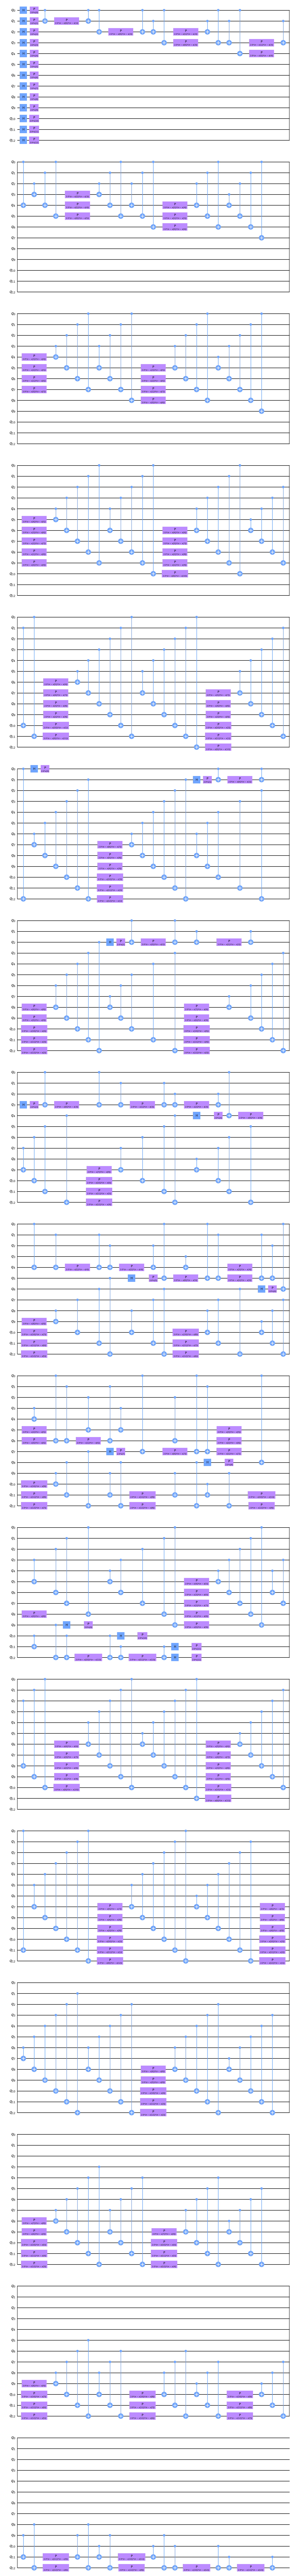

In [6]:
#Primero escogemos un método de encoding. En nuestro caso optamos por el ZZFeatureMap
from qiskit.circuit.library import ZZFeatureMap
featureMap = ZZFeatureMap(feature_dimension=13, reps=2)
featureMap.decompose().draw("mpl")


#### Circuito clasificador

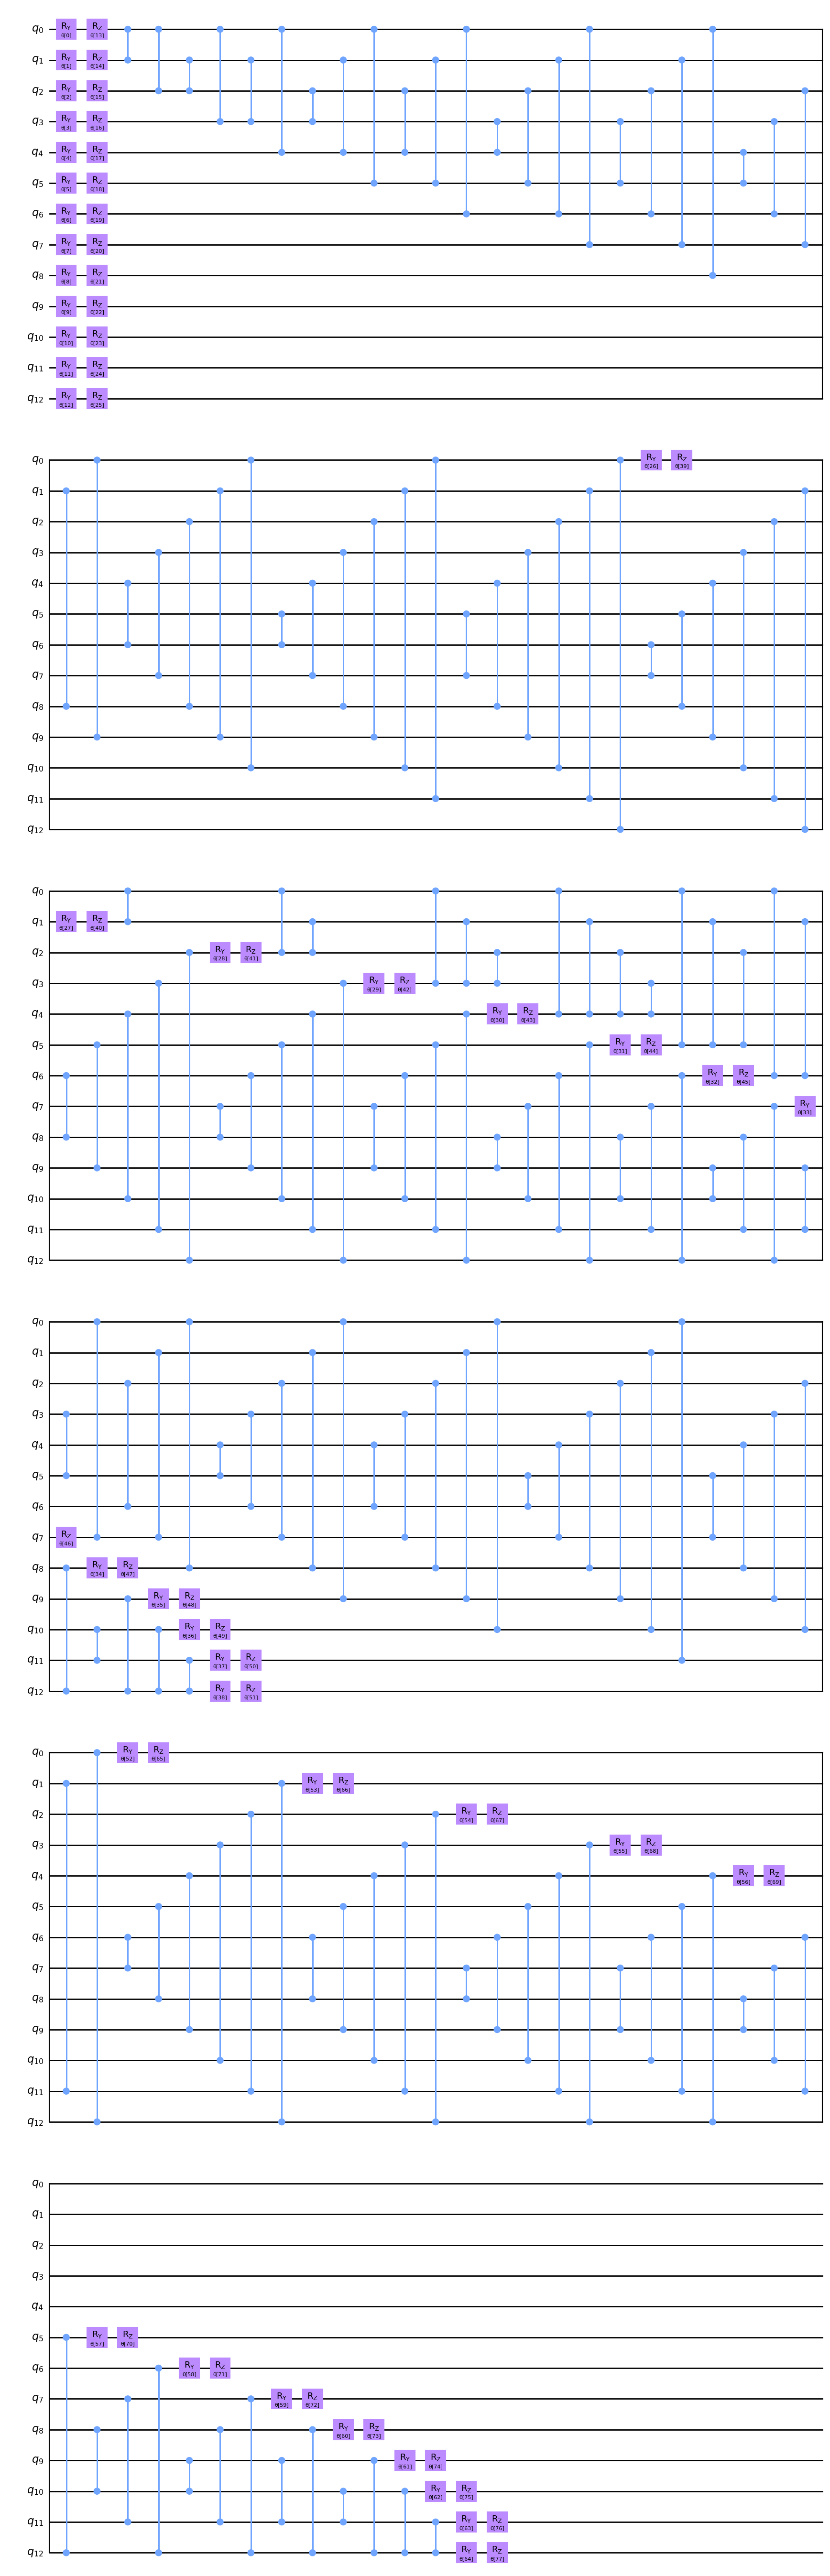

In [7]:
#Para el circuito clasificador utilizaremos TwoLocal
from qiskit.circuit.library import TwoLocal
classifier = TwoLocal(13, ['ry', 'rz'], 'cz', reps=2)
classifier.decompose().draw("mpl")

#### Optimizador 


In [8]:
#Hemos escogido el SPSA optimizer con la función de log de los apuntes
from qiskit.algorithms.optimizers import SPSA

class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

log = OptimizerLog()

optimizer = SPSA(maxiter=100, callback=log.update)


C:\Users\odnan\AppData\Local\Temp\ipykernel_22488\3782069441.py:2: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import SPSA


#### VQC

In [13]:
#Generamos un VQC con todas las opciones definidas anteriormente
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(feature_map=featureMap,
          ansatz=classifier,
          loss='cross_entropy',
          optimizer=SPSA(callback=log.update)) #, quantum_instance=BasicAer.get_backend('qasm_simulator'))


### Ejecución de la QNN

In [14]:
#Entrenamos el modelo
vqc.fit(features_train, labels_train)

#Ploteamos los resultados
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

AttributeError: 'MinMaxScaler' object has no attribute 'shape'

### Variaciones

### Conclusiones